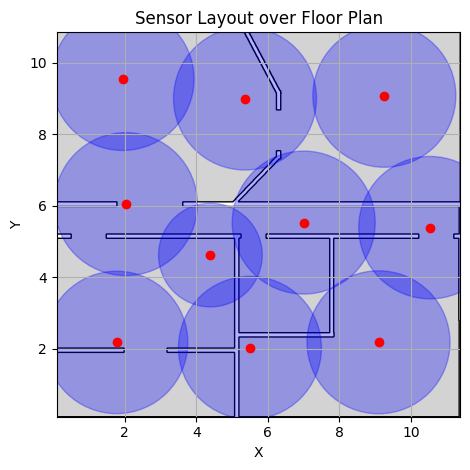

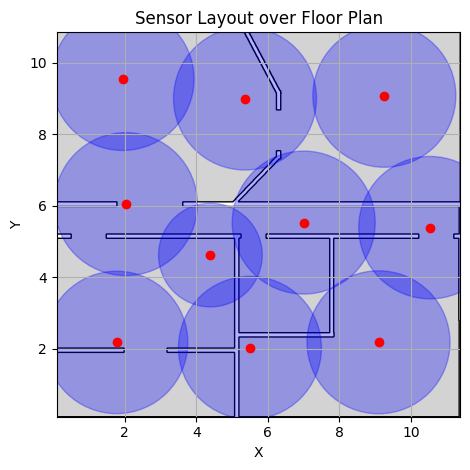

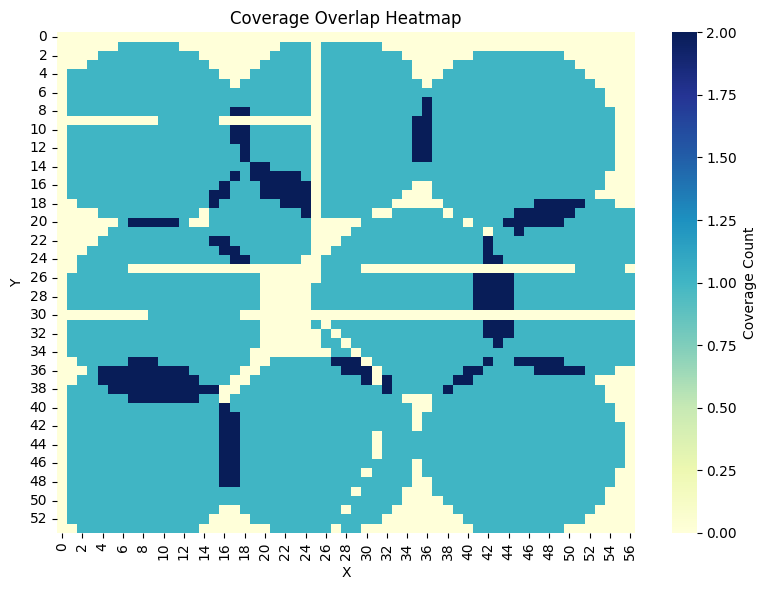

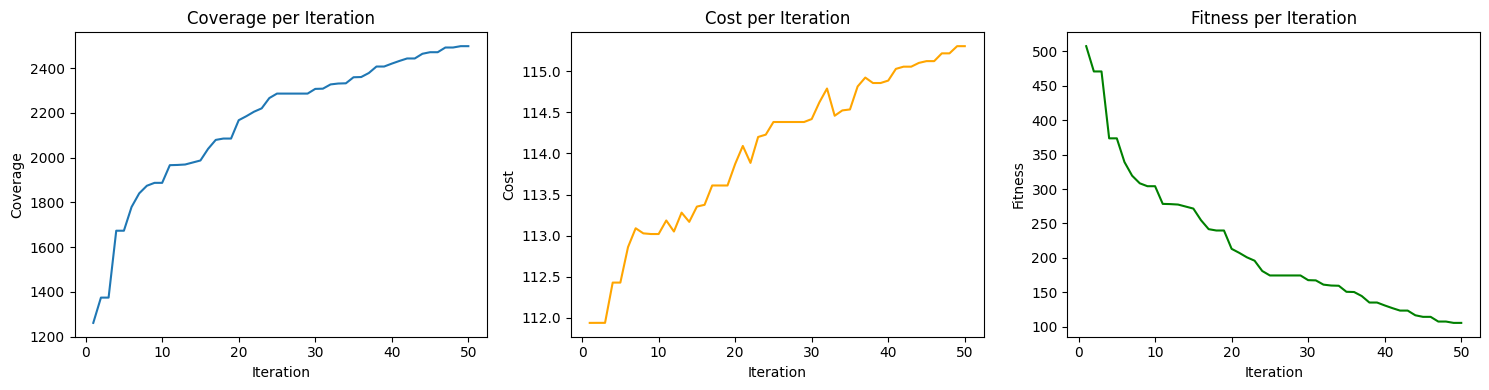

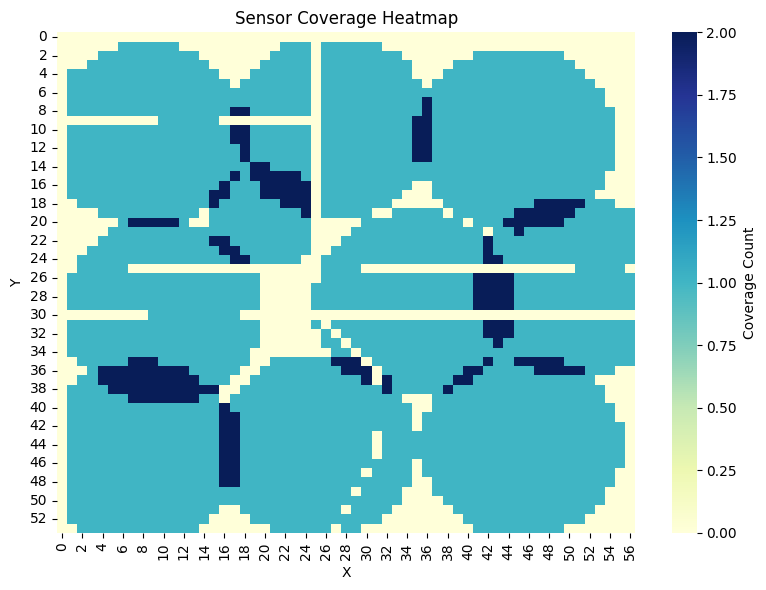

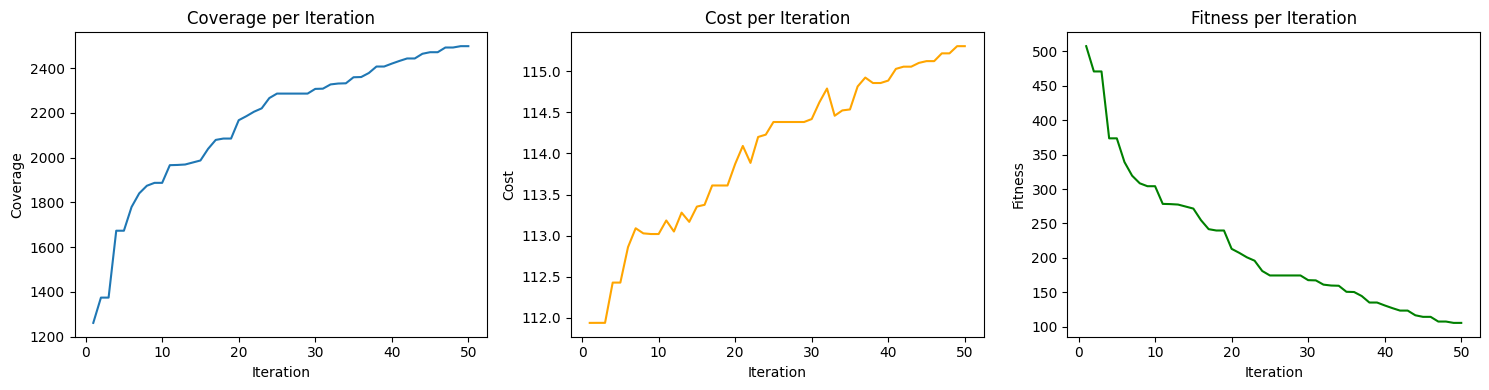

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from matplotlib.patches import Polygon
from matplotlib.path import Path

# ---------------- Load Layout from JSON ----------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
min_x, min_y = layout_data["bbox"]["min"]
max_x, max_y = layout_data["bbox"]["max"]

# ---------------- 1. Configuration ----------------
params = {
    "sensor_count": 10,
    "r_min": 0.5,
    "r_max": 2.0,
    "fixed_cost": 10.0,
    "cost_per_radius": 0.8,
    "min_coverage_per_point": 1,
    "grid_resolution": 0.2,
    "swarm_size": 30,
    "max_iter": 50,
    "ga_generations": 20,
    "mutation_rate": 0.2
}
params["area_width"] = max_x - min_x
params["area_height"] = max_y - min_y

# ---------------- 2. Grid Setup ----------------
x_coords = np.arange(min_x, max_x, params["grid_resolution"])
y_coords = np.arange(min_y, max_y, params["grid_resolution"])
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]
room_path = Path(polygon_coords)

dim = params["sensor_count"] * 3
lb = np.tile([min_x, min_y, params["r_min"]], params["sensor_count"])
ub = np.tile([max_x, max_y, params["r_max"]], params["sensor_count"])
EPS = 1e-6
PENALTY = 1000

fitness_history = []
coverage_history = []
cost_history = []
position_history = []

# ---------------- 3. Fitness Function ----------------
def fitness(x):
    global last_heatmap
    coverage = np.zeros(len(GRID), dtype=int)
    cost = 0.0

    for i in range(params["sensor_count"]):
        x_s, y_s, r = x[i*3:i*3+3]
        dist = np.hypot(GRID[:, 0] - x_s, GRID[:, 1] - y_s)
        cover_mask = (dist <= r) & room_path.contains_points(GRID)
        coverage += cover_mask.astype(int)
        cost += params["fixed_cost"] + params["cost_per_radius"] * r

    uncovered = np.sum((coverage < params["min_coverage_per_point"]) & room_path.contains_points(GRID))
    F1 = cost
    F2 = np.sum((coverage >= params["min_coverage_per_point"]) & room_path.contains_points(GRID))
    last_heatmap = coverage
    if F2 == 0:
        return float("inf"), F1, F2
    penalty = PENALTY * (uncovered / len(GRID))
    return F1 / (F2 + EPS) + penalty, F1, F2

# ---------------- 4. PSO + GA ----------------
V_MAX_FACTOR = 0.2
W_INERTIA = 0.7
C1 = 1.5
C2 = 1.5

np.random.seed(42)
pos = np.random.uniform(lb, ub, (params["swarm_size"], dim))
vel = np.random.uniform(-1, 1, (params["swarm_size"], dim)) * (ub - lb) * V_MAX_FACTOR
pbest_pos = pos.copy()
pbest_val = np.full(params["swarm_size"], np.inf)
gbest_val = np.inf
gbest_pos = None

start_time = time.perf_counter()

for t in range(params["max_iter"]):
    for i in range(params["swarm_size"]):
        f, f1, f2 = fitness(pos[i])
        if f < pbest_val[i]:
            pbest_val[i] = f
            pbest_pos[i] = pos[i].copy()
        if f < gbest_val:
            gbest_val = f
            gbest_pos = pos[i].copy()
            best_cost = f1
            best_coverage = f2

    fitness_history.append(gbest_val)
    cost_history.append(best_cost)
    coverage_history.append(best_coverage)
    position_history.append(gbest_pos.copy())

    # --- GA Search
    for _ in range(params["ga_generations"]):
        children = []
        for _ in range(3):
            idx = np.random.choice(len(pbest_pos), 2, replace=False)
            p1, p2 = pbest_pos[idx[0]], pbest_pos[idx[1]]
            cross = np.where(np.random.rand(dim) < 0.5, p1, p2)
            if np.random.rand() < params["mutation_rate"]:
                mi = np.random.randint(0, dim)
                cross[mi] += np.random.normal(0, 0.1 * (ub[mi] - lb[mi]))
            cross = np.clip(cross, lb, ub)
            children.append(cross)
        for child in children:
            f, f1, f2 = fitness(child)
            if f < gbest_val:
                gbest_val = f
                gbest_pos = child.copy()
                best_cost = f1
                best_coverage = f2

    # --- PSO Update
    r1, r2 = np.random.rand(params["swarm_size"], dim), np.random.rand(params["swarm_size"], dim)
    vel = (W_INERTIA * vel +
           C1 * r1 * (pbest_pos - pos) +
           C2 * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -V_MAX_FACTOR * (ub - lb), V_MAX_FACTOR * (ub - lb))
    pos = np.clip(pos + vel, lb, ub)

runtime = time.perf_counter() - start_time

# ---------------- 5. Visualization ----------------
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_title("Sensor Layout over Floor Plan")
ax.add_patch(Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='lightgray', linewidth=1))

for i in range(params["sensor_count"]):
    x, y, r = gbest_pos[i*3], gbest_pos[i*3+1], gbest_pos[i*3+2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3))
    ax.plot(x, y, 'ro')

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 6. Heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from matplotlib.patches import Polygon
from matplotlib.path import Path

# ---------------- Load Layout from JSON ----------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
min_x, min_y = layout_data["bbox"]["min"]
max_x, max_y = layout_data["bbox"]["max"]

# ---------------- 1. Configuration ----------------
params = {
    "sensor_count": 10,
    "r_min": 0.5,
    "r_max": 2.0,
    "fixed_cost": 10.0,
    "cost_per_radius": 0.8,
    "min_coverage_per_point": 1,
    "grid_resolution": 0.2,
    "swarm_size": 30,
    "max_iter": 50,
    "ga_generations": 20,
    "mutation_rate": 0.2
}
params["area_width"] = max_x - min_x
params["area_height"] = max_y - min_y

# ---------------- 2. Grid Setup ----------------
x_coords = np.arange(min_x, max_x, params["grid_resolution"])
y_coords = np.arange(min_y, max_y, params["grid_resolution"])
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]
room_path = Path(polygon_coords)

dim = params["sensor_count"] * 3
lb = np.tile([min_x, min_y, params["r_min"]], params["sensor_count"])
ub = np.tile([max_x, max_y, params["r_max"]], params["sensor_count"])
EPS = 1e-6
PENALTY = 1000

fitness_history = []
coverage_history = []
cost_history = []
position_history = []

# ---------------- 3. Fitness Function ----------------
def fitness(x):
    global last_heatmap
    coverage = np.zeros(len(GRID), dtype=int)
    cost = 0.0

    for i in range(params["sensor_count"]):
        x_s, y_s, r = x[i*3:i*3+3]
        dist = np.hypot(GRID[:, 0] - x_s, GRID[:, 1] - y_s)
        cover_mask = (dist <= r) & room_path.contains_points(GRID)
        coverage += cover_mask.astype(int)
        cost += params["fixed_cost"] + params["cost_per_radius"] * r

    uncovered = np.sum((coverage < params["min_coverage_per_point"]) & room_path.contains_points(GRID))
    F1 = cost
    F2 = np.sum((coverage >= params["min_coverage_per_point"]) & room_path.contains_points(GRID))
    last_heatmap = coverage
    if F2 == 0:
        return float("inf"), F1, F2
    penalty = PENALTY * (uncovered / len(GRID))
    return F1 / (F2 + EPS) + penalty, F1, F2

# ---------------- 4. PSO + GA ----------------
V_MAX_FACTOR = 0.2
W_INERTIA = 0.7
C1 = 1.5
C2 = 1.5

np.random.seed(42)
pos = np.random.uniform(lb, ub, (params["swarm_size"], dim))
vel = np.random.uniform(-1, 1, (params["swarm_size"], dim)) * (ub - lb) * V_MAX_FACTOR
pbest_pos = pos.copy()
pbest_val = np.full(params["swarm_size"], np.inf)
gbest_val = np.inf
gbest_pos = None

start_time = time.perf_counter()

for t in range(params["max_iter"]):
    for i in range(params["swarm_size"]):
        f, f1, f2 = fitness(pos[i])
        if f < pbest_val[i]:
            pbest_val[i] = f
            pbest_pos[i] = pos[i].copy()
        if f < gbest_val:
            gbest_val = f
            gbest_pos = pos[i].copy()
            best_cost = f1
            best_coverage = f2

    fitness_history.append(gbest_val)
    cost_history.append(best_cost)
    coverage_history.append(best_coverage)
    position_history.append(gbest_pos.copy())

    # --- GA Search
    for _ in range(params["ga_generations"]):
        children = []
        for _ in range(3):
            idx = np.random.choice(len(pbest_pos), 2, replace=False)
            p1, p2 = pbest_pos[idx[0]], pbest_pos[idx[1]]
            cross = np.where(np.random.rand(dim) < 0.5, p1, p2)
            if np.random.rand() < params["mutation_rate"]:
                mi = np.random.randint(0, dim)
                cross[mi] += np.random.normal(0, 0.1 * (ub[mi] - lb[mi]))
            cross = np.clip(cross, lb, ub)
            children.append(cross)
        for child in children:
            f, f1, f2 = fitness(child)
            if f < gbest_val:
                gbest_val = f
                gbest_pos = child.copy()
                best_cost = f1
                best_coverage = f2

    # --- PSO Update
    r1, r2 = np.random.rand(params["swarm_size"], dim), np.random.rand(params["swarm_size"], dim)
    vel = (W_INERTIA * vel +
           C1 * r1 * (pbest_pos - pos) +
           C2 * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -V_MAX_FACTOR * (ub - lb), V_MAX_FACTOR * (ub - lb))
    pos = np.clip(pos + vel, lb, ub)

runtime = time.perf_counter() - start_time

# ---------------- 5. Visualization ----------------
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_title("Sensor Layout over Floor Plan")
ax.add_patch(Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='lightgray', linewidth=1))

for i in range(params["sensor_count"]):
    x, y, r = gbest_pos[i*3], gbest_pos[i*3+1], gbest_pos[i*3+2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3))
    ax.plot(x, y, 'ro')

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- Heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu', cbar_kws={'label': 'Coverage Count'})
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ---------------- 7. Convergence ----------------
iterations = list(range(1, len(fitness_history) + 1))
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, label="Coverage")
plt.title("Coverage per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage")

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, label="Cost", color="orange")
plt.title("Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, label="Fitness", color="green")
plt.title("Fitness per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")

plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu', cbar_kws={'label': 'Coverage Count'})
plt.title('Sensor Coverage Heatmap')
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 7. Convergence ----------------
iterations = list(range(1, len(fitness_history) + 1))
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, label="Coverage")
plt.title("Coverage per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage")

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, label="Cost", color="orange")
plt.title("Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, label="Fitness", color="green")
plt.title("Fitness per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")

plt.tight_layout()
plt.show()
